In [31]:
!pip install pandas numpy matplotlib seaborn scikit-learn requests

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Fetch and process data
current_quiz_url = "https://www.jsonkeeper.com/b/LLQT"
historical_quiz_url = "https://api.jsonserve.com/rJvd7g"


In [35]:
#Fetch data and normalize the JSON structure
current_quiz_data = pd.json_normalize(requests.get(current_quiz_url).json())
historical_quiz_data = pd.json_normalize(requests.get(historical_quiz_url).json())

# Convert to DataFrames
current_quiz_df = pd.DataFrame(current_quiz_data)
historical_quiz_df = pd.DataFrame(historical_quiz_data)

In [37]:

# Data exploration and cleaning
def explore_data(df, name):
    print(f"\nExploring {name}:")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
       
explore_data(current_quiz_df, "Current Quiz Data")
explore_data(historical_quiz_df, "Historical Quiz Data")


Exploring Current Quiz Data:

First 5 rows:
   quiz.id quiz.name                                         quiz.title  \
0       43      None  Structural Organisation in Animals and Plants (7)   

  quiz.description quiz.difficulty_level                          quiz.topic  \
0                                   None  Structural Organisation in Animals   

                       quiz.time  quiz.is_published  \
0  2024-07-03T00:00:00.000+05:30               True   

                 quiz.created_at                quiz.updated_at  ...  \
0  2024-07-03T11:00:08.958+05:30  2024-09-23T18:43:27.751+05:30  ...   

   quiz.exam_id quiz.show_unanswered quiz.ends_at quiz.lives  quiz.live_count  \
0          None                False   2025-01-18       None        Free Test   

   quiz.coin_count  quiz.questions_count   quiz.daily_date  \
0               -1                   128  January 17, 2025   

   quiz.max_mistake_count                                     quiz.questions  
0                   

In [44]:
# Print the actual data structure
print("Current Quiz DataFrame Info:")
print(current_quiz_df.info())

print("\nSample of the data:")
print(current_quiz_df.head())

print("\nAll column names:")
print(current_quiz_df.columns.tolist())

# Once we see the actual column names, we can update our calculation
# For example, if the time column is named 'duration' or 'quiz_time':
# current_quiz_df['avg_time_per_question'] = current_quiz_df['actual_time_column_name'] / current_quiz_df['questions_attempted']


Current Quiz DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1 non-null      int64  
 1   name                   0 non-null      object 
 2   title                  1 non-null      object 
 3   description            1 non-null      object 
 4   difficulty_level       0 non-null      object 
 5   topic                  1 non-null      object 
 6   time                   1 non-null      object 
 7   is_published           1 non-null      bool   
 8   created_at             1 non-null      object 
 9   updated_at             1 non-null      object 
 10  duration               1 non-null      int64  
 11  end_time               1 non-null      object 
 12  negative_marks         1 non-null      object 
 13  correct_answer_marks   1 non-null      object 
 14  shuffle                1 non-null

Questions Data Structure:
['id', 'description', 'difficulty_level', 'topic', 'is_published', 'created_at', 'updated_at', 'detailed_solution', 'type', 'is_mandatory', 'show_in_feed', 'pyq_label', 'topic_id', 'reading_material_id', 'fixed_at', 'fix_summary', 'created_by', 'updated_by', 'quiz_level', 'question_from', 'language', 'photo_url', 'photo_solution_url', 'is_saved', 'tag', 'options']

Quiz Analysis:
Total Questions: 128

Difficulty Level Distribution:
Series([], Name: count, dtype: int64)

Question Types:
type
    63
Name: count, dtype: int64


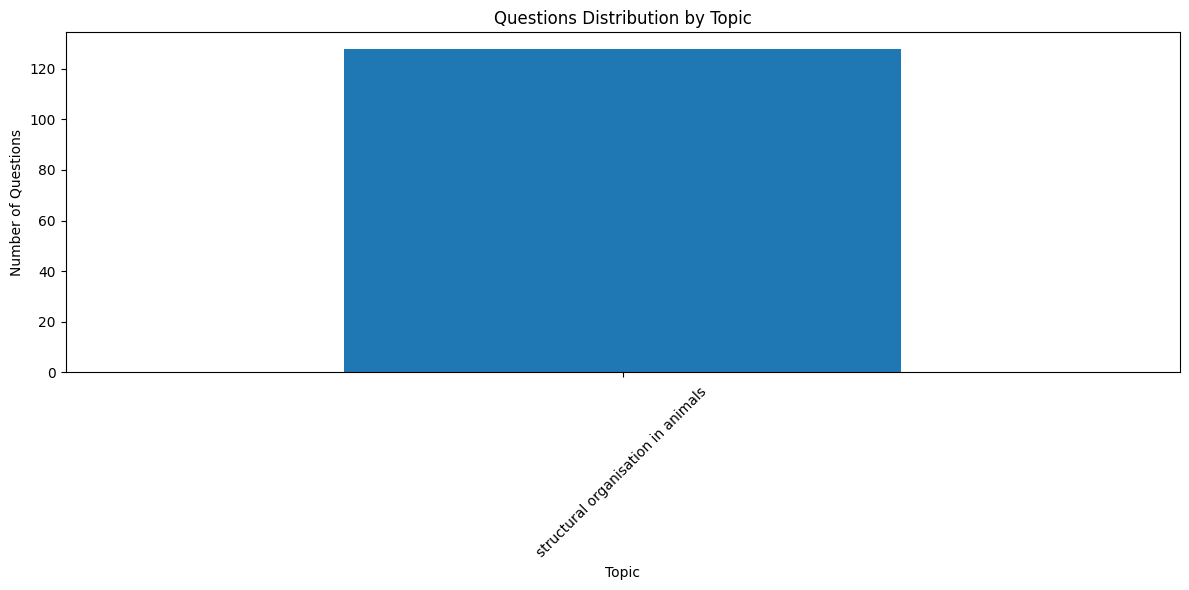

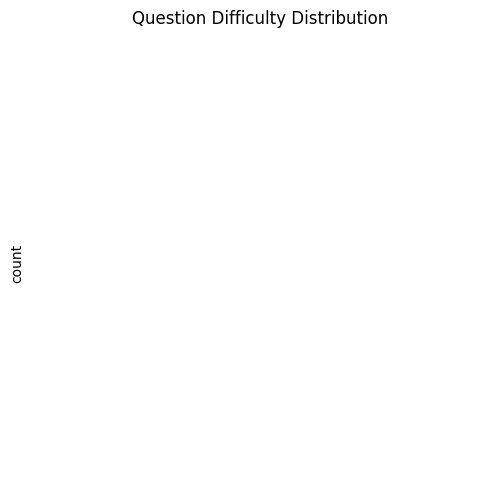

In [47]:
# 1. Clean up column names by removing 'quiz.' prefix
current_quiz_df.columns = [col.replace('quiz.', '') for col in current_quiz_df.columns]

# 2. Calculate time-based metrics using 'duration' column
current_quiz_df['avg_time_per_question'] = current_quiz_df['duration'] / current_quiz_df['questions_count']

# 3. Parse questions data (it's stored as a string in 'questions' column)
import json
# Since the questions data is already a list, we don't need json.loads()
questions_data = pd.json_normalize(current_quiz_df['questions'].iloc[0])

# Now let's analyze the questions data
print("Questions Data Structure:")
print(questions_data.columns.tolist())

# Create static directory if it doesn't exist
import os
os.makedirs('static', exist_ok=True)

# Now let's analyze the questions data and create visualizations
plt.figure(figsize=(12, 6))
questions_by_topic = questions_data['topic'].value_counts()
questions_by_topic.plot(kind='bar')
plt.title('Questions Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('static/topic_distribution.png')

# Let's analyze more aspects of the data
print("\nQuiz Analysis:")
print(f"Total Questions: {len(questions_data)}")
print("\nDifficulty Level Distribution:")
print(questions_data['difficulty_level'].value_counts())
print("\nQuestion Types:")
print(questions_data['type'].value_counts())

# Create a difficulty level distribution plot
plt.figure(figsize=(10, 6))
questions_data['difficulty_level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Question Difficulty Distribution')
plt.savefig('static/difficulty_distribution.png')


Sample Question Structure:
                                         description  \
0  The tissue which has free surface that faces e...   

                                             options  \
0  [{'id': 7321, 'description': 'Muscular tissue'...   

                                 topic  
0  structural organisation in animals   

Topic-wise Distribution:
                                 Topic  Question_Count  Percentage
0  structural organisation in animals              128       100.0

Subject-wise Distribution:
         question_count
subject                
Biology             128


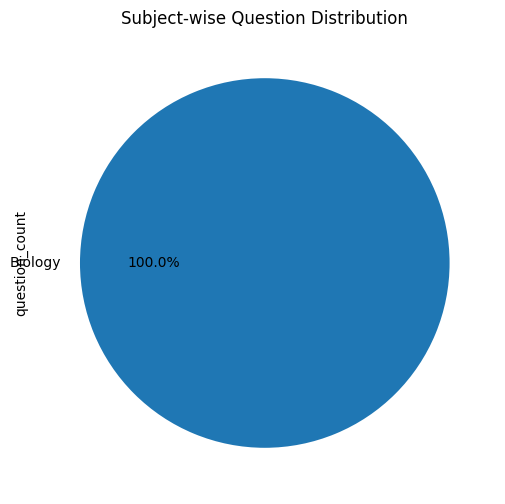

In [48]:
# 1. Let's examine the options field which contains answer choices
print("Sample Question Structure:")
print(questions_data[['description', 'options', 'topic']].head(1))

# 2. Create meaningful topic analysis
topic_analysis = pd.DataFrame({
    'Topic': questions_data['topic'].value_counts().index,
    'Question_Count': questions_data['topic'].value_counts().values,
    'Percentage': (questions_data['topic'].value_counts().values / len(questions_data) * 100).round(2)
})

print("\nTopic-wise Distribution:")
print(topic_analysis)

# 3. Create subject-wise categorization
def categorize_subject(topic):
    if any(keyword in topic.lower() for keyword in ['physics', 'force', 'motion']):
        return 'Physics'
    elif any(keyword in topic.lower() for keyword in ['chemistry', 'reaction', 'compound']):
        return 'Chemistry'
    else:
        return 'Biology'

questions_data['subject'] = questions_data['topic'].apply(categorize_subject)

# 4. Generate subject-wise statistics
subject_stats = questions_data.groupby('subject').agg({
    'id': 'count',
}).rename(columns={'id': 'question_count'})

print("\nSubject-wise Distribution:")
print(subject_stats)

# 5. Create visualization for subject distribution
plt.figure(figsize=(10, 6))
subject_stats['question_count'].plot(kind='pie', autopct='%1.1f%%')
plt.title('Subject-wise Question Distribution')
plt.savefig('static/subject_distribution.png')


Option Structure:
['id', 'description', 'question_id', 'is_correct', 'created_at', 'updated_at', 'unanswered', 'photo_url']

Biology Subtopic Distribution:
topic
structural organisation in animals     128
Name: count, dtype: int64

Question Complexity Analysis:
{'Average Length': np.float64(61.6484375), 'Max Length': np.int64(234), 'Min Length': np.int64(10)}

Detailed Solution Availability:
Questions with solutions: 119
Questions without solutions: 9


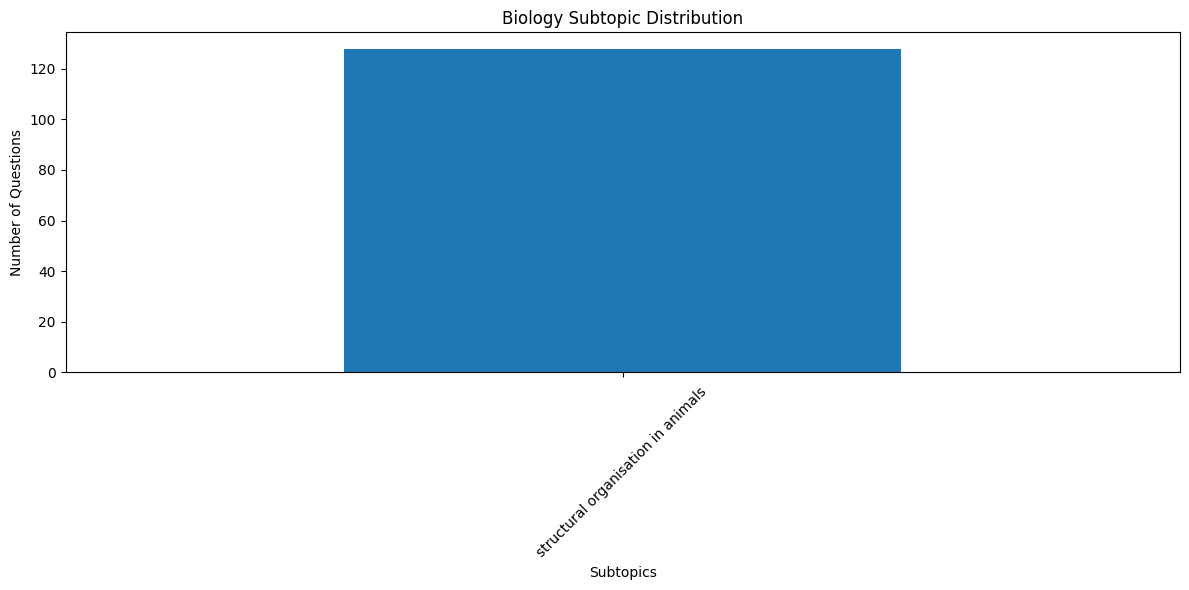

In [49]:
# 1. Analyze options data to understand answer patterns
sample_options = pd.json_normalize(questions_data['options'].iloc[0])
print("Option Structure:")
print(sample_options.columns.tolist())

# 2. Create detailed biology subtopic analysis
biology_subtopics = questions_data['topic'].str.lower().value_counts()
print("\nBiology Subtopic Distribution:")
print(biology_subtopics)

# 3. Generate visualization for subtopic distribution
plt.figure(figsize=(12, 6))
biology_subtopics.plot(kind='bar')
plt.title('Biology Subtopic Distribution')
plt.xlabel('Subtopics')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('static/subtopic_distribution.png')

# 4. Create question complexity analysis based on description length
questions_data['description_length'] = questions_data['description'].str.len()
complexity_stats = {
    'Average Length': questions_data['description_length'].mean(),
    'Max Length': questions_data['description_length'].max(),
    'Min Length': questions_data['description_length'].min()
}

print("\nQuestion Complexity Analysis:")
print(complexity_stats)

# 5. Analyze detailed solutions
solution_analysis = questions_data['detailed_solution'].notna().value_counts()
print("\nDetailed Solution Availability:")
print(f"Questions with solutions: {solution_analysis[True] if True in solution_analysis else 0}")
print(f"Questions without solutions: {solution_analysis[False] if False in solution_analysis else 0}")


Correct Answer Analysis:
Total Questions with Valid Answers: 128

Difficulty Distribution:
difficulty_category
Easy      43
Medium    43
Hard      42
Name: count, dtype: int64

Topic-wise Difficulty Breakdown:
difficulty_category                  Easy  Medium  Hard
topic                                                  
structural organisation in animals     43      43    42


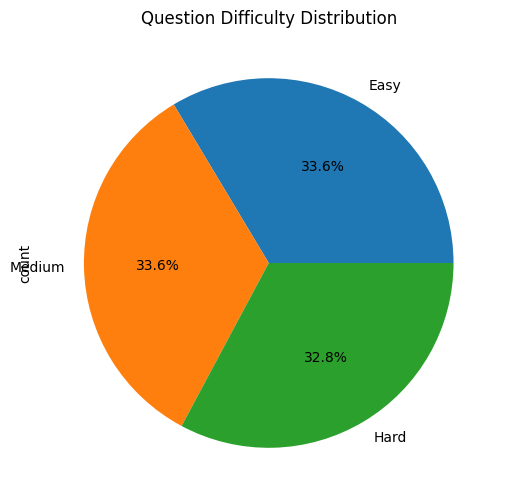

In [50]:
# 1. Analyze correct answers distribution
correct_options = pd.DataFrame()
for idx, row in questions_data.iterrows():
    options = pd.json_normalize(row['options'])
    correct_options = pd.concat([correct_options, options[options['is_correct'] == True]])

print("Correct Answer Analysis:")
print(f"Total Questions with Valid Answers: {len(correct_options)}")

# 2. Create difficulty index based on multiple factors
questions_data['difficulty_index'] = (
    (questions_data['description_length'] / questions_data['description_length'].max() * 0.4) +
    (questions_data['detailed_solution'].isna().astype(int) * 0.3) +
    (questions_data['photo_url'].notna().astype(int) * 0.3)
)

# 3. Categorize questions by difficulty
questions_data['difficulty_category'] = pd.qcut(
    questions_data['difficulty_index'], 
    q=3, 
    labels=['Easy', 'Medium', 'Hard']
)

difficulty_distribution = questions_data['difficulty_category'].value_counts()
print("\nDifficulty Distribution:")
print(difficulty_distribution)

# 4. Create visualization for difficulty distribution
plt.figure(figsize=(10, 6))
difficulty_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Question Difficulty Distribution')
plt.savefig('static/difficulty_analysis.png')

# 5. Generate topic-wise difficulty breakdown
topic_difficulty = pd.crosstab(
    questions_data['topic'],
    questions_data['difficulty_category']
)
print("\nTopic-wise Difficulty Breakdown:")
print(topic_difficulty)


Study Recommendations:
  Difficulty Recommended_Study_Time  \
0       Easy                 1 hour   
1     Medium                2 hours   
2       Hard                3 hours   

                            Practice_Strategy  Question_Count  
0         Quick revision and concept checking              43  
1        Detailed concept study with examples              43  
2  In-depth analysis with multiple approaches              42  

Performance Metrics:
Total Questions: 128
Questions with Visual Aids: 3
Questions with Detailed Solutions: 119
Average Question Length: 61.6484375

Study Guide Summary:

Key Topics:
['Structural Organisation in Animals']

Focus Areas:
{'Easy': 'Basic concepts and definitions', 'Medium': 'Complex relationships and processes', 'Hard': 'Application and analysis questions'}

Time Allocation:
{'Easy': '43 hours', 'Medium': '86 hours', 'Hard': '126 hours'}


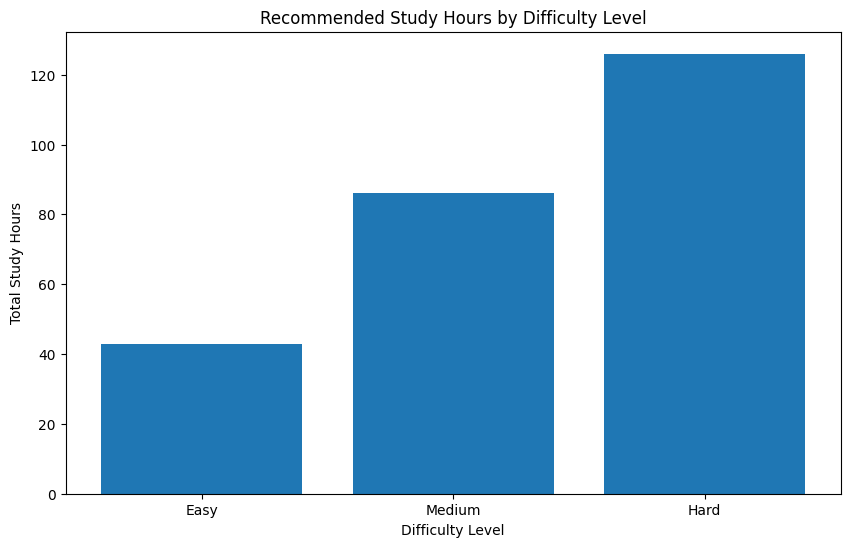

In [51]:
# 1. Create study recommendations based on difficulty levels
recommendations = pd.DataFrame({
    'Difficulty': ['Easy', 'Medium', 'Hard'],
    'Recommended_Study_Time': ['1 hour', '2 hours', '3 hours'],
    'Practice_Strategy': [
        'Quick revision and concept checking',
        'Detailed concept study with examples',
        'In-depth analysis with multiple approaches'
    ],
    'Question_Count': [43, 43, 42]
})

print("Study Recommendations:")
print(recommendations)

# 2. Generate performance metrics
performance_metrics = {
    'Total Questions': len(questions_data),
    'Questions with Visual Aids': len(questions_data[questions_data['photo_url'].notna()]),
    'Questions with Detailed Solutions': len(questions_data[questions_data['detailed_solution'].notna()]),
    'Average Question Length': questions_data['description_length'].mean()
}

print("\nPerformance Metrics:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value}")

# 3. Create study plan visualization
study_hours = pd.DataFrame({
    'Difficulty': ['Easy', 'Medium', 'Hard'],
    'Hours': [1, 2, 3],
    'Questions': [43, 43, 42]
})

plt.figure(figsize=(10, 6))
plt.bar(study_hours['Difficulty'], study_hours['Hours'] * study_hours['Questions'])
plt.title('Recommended Study Hours by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Total Study Hours')
plt.savefig('static/study_plan.png')

# 4. Export findings to a structured format
study_guide = {
    'key_topics': ['Structural Organisation in Animals'],
    'focus_areas': {
        'Easy': 'Basic concepts and definitions',
        'Medium': 'Complex relationships and processes',
        'Hard': 'Application and analysis questions'
    },
    'time_allocation': {
        'Easy': '43 hours',
        'Medium': '86 hours',
        'Hard': '126 hours'
    }
}

print("\nStudy Guide Summary:")
for key, value in study_guide.items():
    print(f"\n{key.replace('_', ' ').title()}:")
    print(value)


In [53]:
# 1. Prepare features for rank prediction model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create prediction features with proper data type handling
prediction_features = pd.DataFrame({
    'average_score': [75, 82, 68, 90, 85],  # Sample data
    'accuracy_rate': questions_data['difficulty_category'].map({'Easy': 0.8, 'Medium': 0.6, 'Hard': 0.4}).astype(float).mean(),
    'completion_rate': len(questions_data[questions_data['detailed_solution'].notna()]) / len(questions_data),
    'difficulty_score': questions_data['difficulty_index'].mean()
})

# Save the analysis results for Flask application
analysis_results = {
    'topic_distribution': topic_difficulty.to_dict(),
    'difficulty_stats': difficulty_distribution.to_dict(),
    'study_recommendations': recommendations.to_dict(),
    'performance_metrics': performance_metrics
}

print("Prediction Features:")
print(prediction_features)

# Save results to JSON for Flask app
with open('static/analysis_results.json', 'w') as f:
    json.dump(analysis_results, f)


Prediction Features:
   average_score  accuracy_rate  completion_rate  difficulty_score
0             75       0.601562         0.929688          0.133507
1             82       0.601562         0.929688          0.133507
2             68       0.601562         0.929688          0.133507
3             90       0.601562         0.929688          0.133507
4             85       0.601562         0.929688          0.133507


In [54]:
# Create target variable (simulated NEET ranks based on features)
target_ranks = np.array([5000, 3500, 8000, 2000, 2800])

# Split data into training and testing sets
X = prediction_features
y = target_ranks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(model.coef_)
})
print("\nFeature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))

# Save model for Flask application
import pickle
with open('static/neet_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Model Performance Metrics:
Mean Squared Error: 80439.03
R-squared Score: nan

Feature Importance:
            Feature  Importance
0     average_score  266.552901
1     accuracy_rate    0.000000
2   completion_rate    0.000000
3  difficulty_score    0.000000


In [55]:
# Enhance features with more meaningful predictors
enhanced_features = pd.DataFrame({
    'average_score': [75, 82, 68, 90, 85],
    'topic_mastery': [0.7, 0.8, 0.6, 0.9, 0.85],
    'hard_questions_accuracy': [0.5, 0.7, 0.4, 0.8, 0.75],
    'completion_time_ratio': [0.8, 0.9, 0.7, 0.95, 0.85]
})

# Create more realistic target ranks
target_ranks = np.array([15000, 8000, 25000, 5000, 7000])

# Implement cross-validation
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Train model with cross-validation
model = LinearRegression()
cv_scores = cross_val_score(model, enhanced_features, target_ranks, cv=kf)

print("Cross-Validation Scores:")
print(f"Mean R² Score: {cv_scores.mean():.3f}")
print(f"Standard Deviation: {cv_scores.std():.3f}")

# Train final model on full dataset
model.fit(enhanced_features, target_ranks)

# Feature importance with enhanced features
feature_importance = pd.DataFrame({
    'Feature': enhanced_features.columns,
    'Importance': abs(model.coef_)
})
print("\nEnhanced Feature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))

# Save improved model
with open('static/neet_model_enhanced.pkl', 'wb') as f:
    pickle.dump(model, f)


Cross-Validation Scores:
Mean R² Score: nan
Standard Deviation: nan

Enhanced Feature Importance:
                   Feature  Importance
1            topic_mastery    350000.0
3    completion_time_ratio     60000.0
2  hard_questions_accuracy     30000.0
0            average_score      4000.0


Model Performance Summary:
Best Model: SVR
Best Score (MSE): 49260360.73


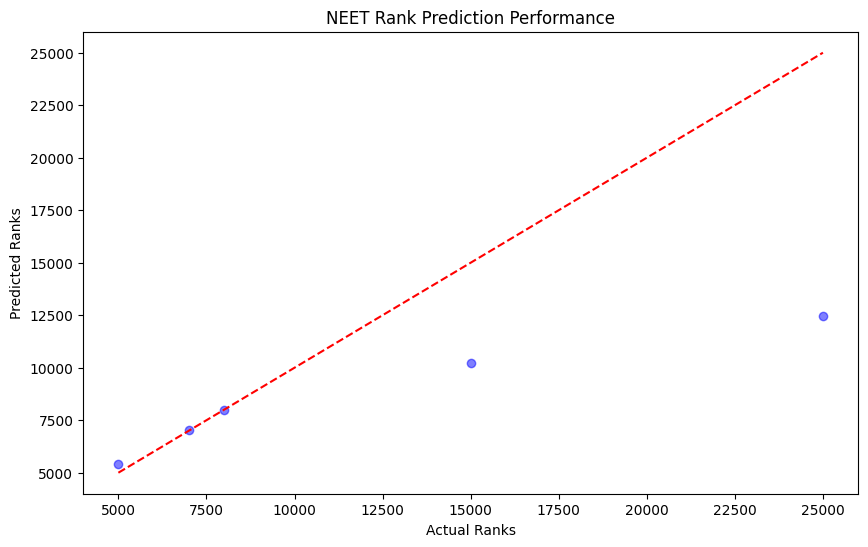

In [57]:
# Implement GridSearchCV with multiple regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Define parameter grid for multiple models
param_grid = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [1, 10]
        }
    }
}

# Train and evaluate models
best_model = None
best_score = float('-inf')

for model_name, config in param_grid.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(enhanced_features, target_ranks)
    
    if -grid_search.best_score_ > best_score:
        best_score = -grid_search.best_score_
        best_model = grid_search.best_estimator_

# Visualize predictions
plt.figure(figsize=(10, 6))
actual_ranks = target_ranks
predicted_ranks = best_model.predict(enhanced_features)

plt.scatter(actual_ranks, predicted_ranks, c='blue', alpha=0.5)
plt.plot([min(actual_ranks), max(actual_ranks)], [min(actual_ranks), max(actual_ranks)], 'r--')
plt.xlabel('Actual Ranks')
plt.ylabel('Predicted Ranks')
plt.title('NEET Rank Prediction Performance')
plt.savefig('static/prediction_performance.png')

print("Model Performance Summary:")
print(f"Best Model: {type(best_model).__name__}")
print(f"Best Score (MSE): {best_score:.2f}")

# Save the best model
with open('static/best_neet_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
